In [18]:
#https://www.eadan.net/blog/german-tank-problem/
import numpy as np
num_tanks = 1000
num_captured = 15
serial_numbers = np.arange(1, num_tanks + 1)
num_simulations = 100_000
def capture_tanks(serial_numbers, n):
     """Capture `n` tanks, uniformly, at random."""
     return np.random.choice(serial_numbers, n, replace=False)
simulations = [
    capture_tanks(serial_numbers, num_captured)
    for _ in range(num_simulations)
]

(array([1.7000e+01, 2.5000e+01, 1.0400e+02, 2.6400e+02, 7.4000e+02,
        2.0330e+03, 4.9160e+03, 1.1239e+04, 2.5310e+04, 5.5352e+04]),
 array([ 488. ,  539.2,  590.4,  641.6,  692.8,  744. ,  795.2,  846.4,
         897.6,  948.8, 1000. ]),
 <a list of 10 Patch objects>)

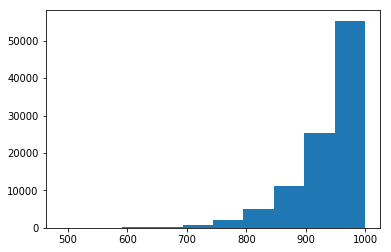

In [20]:
import matplotlib.pyplot as plt
first_estimates = [max(s) for s in simulations]
avg_first_estimates = np.mean(first_estimates)
plt.hist(first_estimates)


In [16]:
#pip install voila --user
!pip install cupy --user

    100% |████████████████████████████████| 3.1MB 5.4MB/s 
    Complete output from command python setup.py egg_info:
    Options: {'package_name': 'cupy', 'long_description': None, 'wheel_libs': [], 'wheel_includes': [], 'no_rpath': False, 'profile': False, 'linetrace': False, 'annotate': False, 'no_cuda': False}
    
    -------- Configuring Module: cuda --------
    cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
    cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
    /opt/conda/compiler_compat/ld: cannot find -lcuda
    collect2: error: ld returned 1 exit status
    Cannot build a stub file.
    Original error: command 'g++' failed with exit status 1
    
    ************************************************************
    * CuPy Configuration Summary                               *
    ************************************************************
    
    Build Environment:
      Include

In [17]:
import cupy as cp
x = cp.arange(6).reshape(2, 3).astype('f')
print(x)
x.sum(axis=1)
#array([  3.,  12.], dtype=float32)

ModuleNotFoundError: No module named 'cupy'

In [14]:
#cuda
import pycuda.autoinit
import pycuda.driver as drv
import numpy

from pycuda.compiler import SourceModule
mod = SourceModule("""
__global__ void multiply_them(float *dest, float *a, float *b)
{
  const int i = threadIdx.x;
  dest[i] = a[i] * b[i];
}
""")

multiply_them = mod.get_function("multiply_them")

a = numpy.random.randn(400).astype(numpy.float32)
b = numpy.random.randn(400).astype(numpy.float32)

dest = numpy.zeros_like(a)
multiply_them(
        drv.Out(dest), drv.In(a), drv.In(b),
        block=(400,1,1), grid=(1,1))

print(dest-a*b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [13]:
#metaprogramming
from jinja2 import Template
thread_block_size=32
tpl = Template("""
    __global__ void add(
            {{ type_name }} *tgt,
            {{ type_name }} *op1,
            {{ type_name }} *op2)
    {
      int idx = threadIdx.x +
        {{ thread_block_size }} * {{block_size}}
        * blockIdx.x;

      {% for i in range(block_size) %}
          {% set offset = i*thread_block_size %}
          tgt[idx + {{ offset }}] =
            op1[idx + {{ offset }}]
            + op2[idx + {{ offset }}];
      {% endfor %}
    }""")

rendered_tpl = tpl.render(
    type_name="float", block_size=block_size,
    thread_block_size=thread_block_size)

mod = SourceModule(rendered_tpl)
print(mod)

In [10]:
!pip install codepy --user

In [6]:
from codepy.cgen import FunctionBody, \
        FunctionDeclaration, Typedef, POD, Value, \
        Pointer, Module, Block, Initializer, Assign
from codepy.cgen.cuda import CudaGlobal

mod = Module([
    FunctionBody(
        CudaGlobal(FunctionDeclaration(
            Value("void", "add"),
            arg_decls=[Pointer(POD(dtype, name))
                for name in ["tgt", "op1", "op2"]])),
        Block([
            Initializer(
                POD(numpy.int32, "idx"),
                "threadIdx.x + %d*blockIdx.x"
                % (thread_block_size*block_size)),
            ]+[
            Assign(
                "tgt[idx+%d]" % (o*thread_block_size),
                "op1[idx+%d] + op2[idx+%d]" % (
                    o*thread_block_size,
                    o*thread_block_size))
            for o in range(block_size)]))])

mod = SourceModule(mod)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: codepy.cgen is deprecated. Use the separate 'cgen' module instead, see the Python package index.
  """Entry point for launching an IPython kernel.


ModuleNotFoundError: No module named 'codepy.cgen.cuda'